# Classifier Certification -- Classifier Performance and Adv Classification Techniques

##### IPython Autotime Magic

In [1]:
# External extension that allows us to time each block automagically
%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime

Installed autotime.py. To use it, type:
  %load_ext autotime


/Users/keenan.hawekotte/anaconda/lib/python2.7/site-packages/IPython/core/magics/extension.py:47: UserWarning: %install_ext` is deprecated, please distribute your extension as a python package.
  "as a python package.", UserWarning)


## Imports

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
% matplotlib inline

import numpy as np
import pandas as pd
import imageio as io
import os, sys
import math
import cPickle

time: 2.51 s


## Data loading functions

In [3]:
def unpickle(file):
    """
    Function to load and unpickle a given file and return a dict
    """
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

def get_data_and_labels(folder, as_img=True, get_meta=True):
    """
    Takes in a folder location and outputs the images.
    Can output the image either as a vector or reformatted as a normal RGB image.
    Can also output metadata of images.
    """
    all_data = []
    all_labels = []
    meta = None
    for file in os.listdir(folder):
        if get_meta and 'meta' in file:
            meta = unpickle(os.path.join(folder, file))
        if not 'data_batch' in file:
            continue
        folder_plus_file = os.path.join(folder, file)
        dict = unpickle(folder_plus_file)
        if as_img:
            images = [to_img(img) for img in dict['data']]
        else:
            images = dict['data']
        all_data.extend(images)
        all_labels.extend(dict['labels'])
    if get_meta:
        return all_data, all_labels, meta
    else:
        return all_data, all_labels

def to_img(data):
    """
    Translates the CIFAR-10 image vectors into RGB images
    """
    img_array = np.zeros((32, 32, 3), dtype='uint8')
    index = 0
    
    for i in range(3):
        for j in range(32):
            for k in range(32):
                img_array[j,k,i] = data[index]
                index += 1
    return img_array

time: 19.2 ms


## Base and Classifier Classes

#### Base Class

In [4]:
class BaseModel:
    def name(self):
        return 'Base Model'
    
    def predict(self, x):
        # always predict background
        return 0
    
    # calculates the performance of the model
    def test(self, XY_test, display=True):
        ses = []
        tp = 0.
        tn = 0.
        fp = 0.
        fn = 0.
        for x, y in XY_test:
            pred = self.predict(x)
            ses.append(y**2.+pred**2.)
            if y == 1:
                if pred >= 0.5:
                    tp += 1
                else:
                    fn += 1
            else:
                if pred < 0.5:
                    tn += 1
                else:
                    fp += 1
        try:
            accuracy = (tp+tn)/(tp+tn+fp+fn)
        except:
            accuracy = np.nan
        try:
            recall = tp/(tp+fn)
        except:
            recall = np.nan
        try:
            precision = tp/(tp+fp)
        except:
            precision = np.nan
            
        results = {'mse': np.mean(ses), 'accuracy': accuracy, 'recall': recall, 'precision': precision, 'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn}
        if display:
            print "Fitted %s Results" % self.name()
            print "Accuracy: %0.2f%%" % (results['accuracy']*100.)
            print "Precision: %0.2f%%" % (results['precision']*100.)
            print "Recall: %0.2f%%" % (results['recall']*100.)
        return results
    
    # displays the model predictions on a grid for both test and training data
    # can also be used to save these plots to file
    def plot_model(self, XY_train, XY_test, display = True):
        x0es_test = {1: [], 0: []}
        x1es_test = {1: [], 0: []}
        for x, y in XY_test:
            x0es_test[y].append(x[0])
            x1es_test[y].append(x[1])

        x0es_train = {1: [], 0: []}
        x1es_train = {1: [], 0: []}
        for x, y in XY_train:
            x0es_train[y].append(x[0])
            x1es_train[y].append(x[1])

        x0min = min(x0es_test[0]+x0es_test[1])
        x0max = max(x0es_test[0]+x0es_test[1])
        x1min = min(x1es_test[0]+x1es_test[1])
        x1max = max(x1es_test[0]+x1es_test[1])

        numx0 = 50
        numx1 = int(np.ceil(numx0*(x1max-x1min)/(x0max-x0min)))
        dx0 = (x0max-x0min)/numx0
        dx1 = (x1max-x1min)/numx1
        values = np.zeros((numx1,numx0))
        for i in range(numx0):
            for j in range(numx1):
                x0 = x0min + i * dx0
                x1 = x1min + j * dx1
                values[j,i] = model.predict(np.asarray([x0,x1]))
                
        f, axarr = plt.subplots(1, 2, figsize=(16.,8.))
        the_extent = (x0min, x0max, x1min, x1max)

        axarr[0].plot(x0es_train[0], x1es_train[0], c='b', linestyle='None', marker='o')
        axarr[0].plot(x0es_train[1], x1es_train[1], c='r', linestyle='None', marker='o')
        axarr[0].imshow(values, cmap='bwr', interpolation='None', extent=the_extent, origin='lowerleft', alpha=1.0)
        axarr[0].set_title('%s (Train)' % model.name())

        axarr[1].plot(x0es_test[0], x1es_test[0], c='b', linestyle='None', marker='o')
        axarr[1].plot(x0es_test[1], x1es_test[1], c='r', linestyle='None', marker='o')
        axarr[1].imshow(values, cmap='bwr', interpolation='None', extent=the_extent, origin='lowerleft', alpha=1.0)
        axarr[1].set_title('%s (Test)' % model.name())

        if not display:
            plt.savefig('%s.jpg' % model.name())
        else:
            plt.show()

time: 92 ms


#### Decision Tree Class

In [5]:
class DecisionTree(BaseModel):
    def train(self, XY_train):
        print "Training is for losers who can't guess the correct answer!"
    
    def predict(self, x):
        if x[0] > 0.7*255:
            return 1 # frogs are green, let's say it's a frog
        elif x[1] > 0.5*255:
            return 0 # ships are blue-ish
        else:
            return 1 # I'm Nostradamus and it's a frog.

time: 3.36 ms


#### Train Test Split Method

In [9]:
def train_test_split(image_data, labels, metadata, class_list, split=0.8, seed=None):
    if not seed:
        seed = 42
    np.random.seed(seed)
    
    df = pd.DataFrame(np.transpose([image_data, labels]), columns=['Data', 'Labels'])
    # Limit it to our wanted labels
    if type(class_list[0]) is int:
        df = df.loc[[x in set(class_list) for x in df.Labels]]
    else:
        df = df.loc[[meta['label_names'][x] in set(class_list) for x in df.Labels]]
    
    # Shuffle dataframe
    df = df.reindex(np.random.permutation(df.index))
    
    split_num = int(len(df) * split)
    train_df = df[:split_num]
    test_df = df[split_num:]
    return train_df.Data.values, train_df.Labels.values, test_df.Data.values, test_df.Labels.values

time: 9.06 ms


## Get the data

#### Download the dataset (OPTIONAL)
##### Note: this downloads the folder to the current working directory of your IPython kernel

In [ ]:
import urllib, tarfile
fn, _ = urllib.urlretrieve("https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz")
with tarfile.open(fn, "r:gz") as tf:
    tf.extract('cifar-10-batches-py')

#### Import the data

In [10]:
# EXAMPLE: data, labels, meta = get_data_and_labels('/Users/keenan.hawekotte/Downloads/cifar-10-batches-py/', as_img=True, get_meta=True)
data, labels, meta = get_data_and_labels('FILE/PATH/HERE', as_img=True, get_meta=True)
# Note: Images are 32x32x3 where R = 0, G = 1, B = 2

time: 35.3 s


#### Train and Test Splits

In [11]:
# Test and train data
train_X, train_Y, test_X, test_Y = train_test_split(data, labels, meta, ['frog', 'ship'])
# Setup the labels to correspond to 0 (frog/6) and 1 (ship/8)
norm_train_Y = np.array([0 if x == 6 else 1 for x in train_Y])
norm_test_Y = np.array([0 if x == 6 else 1 for x in test_Y])

time: 35.2 ms


#### Visualize an image

Ind: 0
Label: frog


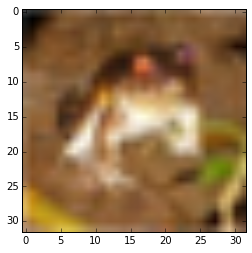

time: 190 ms


In [34]:
ind = 0  # Choose a random image to display

plt.imshow(data[ind])
#plt.colorbar()
image = data[ind]

print 'Ind:', ind
print 'Label:', meta['label_names'][labels[ind]]

## Average color plotting

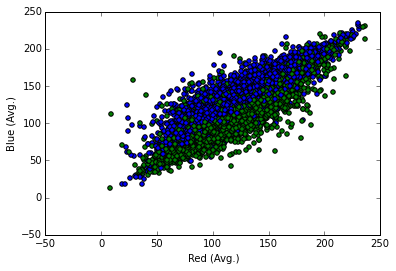

time: 28.3 s


In [6]:
# Plot Colors
fig = plt.figure()
ax = fig.add_subplot(111)
for ind, datum in enumerate(data):
    if meta['label_names'][labels[ind]] == 'ship':
        c = 'b'
    elif meta['label_names'][labels[ind]] == 'frog':
        c = 'g'
    else:
        continue
    tmp_image = datum
    red = np.average(tmp_image[:, :, 0])
    green = np.average(tmp_image[:, :, 1])
    blue = np.average(tmp_image[:, :, 2])
    # You can choose two of the following at any time to display: [hue, saturation, lightness]
    # Make sure you adjust the axes labels below accordingly
    ax.scatter(red, green, c=c)
ax.set_xlabel('Red (Avg.)')
ax.set_ylabel('Blue (Avg.)')

## Colors and Classifiers

In [13]:
# Green then Blue only
train_colors = tuple(np.transpose([[np.average(x[:, :, 1]) for x in train_X], [np.average(x[:, :, 2]) for x in train_X]]))
test_colors = tuple(np.transpose([[np.average(x[:, :, 1]) for x in test_X], [np.average(x[:, :, 2]) for x in test_X]]))

time: 242 ms


### SVM Class

In [6]:
class SVM(BaseModel):
    def train(self, XY_train):
        # calculate normal vector
        self.w = np.average(np.array([x for x, y in XY_train if y==1]), axis=0) \
               - np.average(np.array([x for x, y in XY_train if y==0]), axis=0)

        # calculate offset term
        self.b = 1./len(XY_train)*sum([np.dot(self.w,x)-float(y) for x, y in XY_train])
    def predict(self, x):
        # get sign and then scale it to the range (0,1)
        prediction = (np.sign(np.dot(self.w,x)-self.b)+1)/2
        return prediction
    
    def name(self):
        return 'SVM'

time: 6.63 ms


### Normal SVM

Fitted SVM Results
Accuracy: 76.85%
Precision: 77.06%
Recall: 76.52%


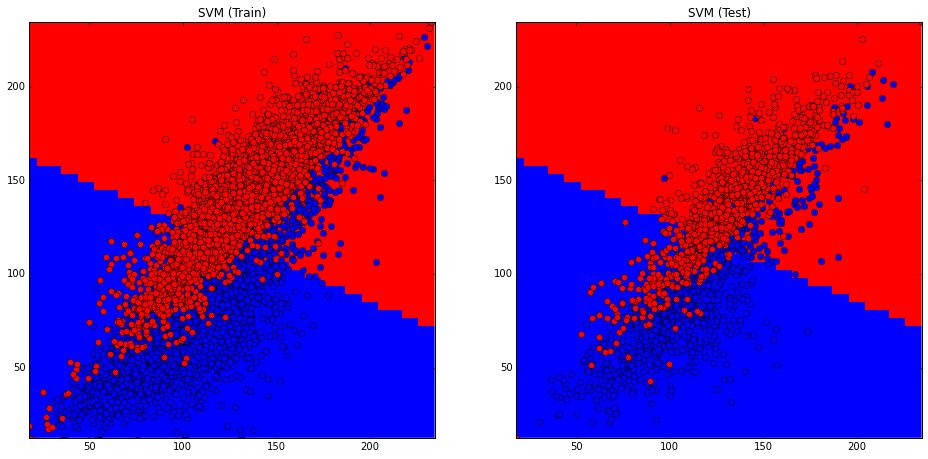

time: 461 ms


In [103]:
# SVM
model = SVM()
model.train(np.transpose((train_colors, norm_train_Y)))
test_results = model.test(np.transpose((test_colors, norm_test_Y)), display=True)
model.plot_model(np.transpose((train_colors, norm_train_Y)), np.transpose((test_colors, norm_test_Y)), display=True)

### SVM Bagging

In [7]:
class SVM_Bagging(BaseModel):
    def __init__(self, num_bags=5, size_bags=None, size_percent=None):
        self.n = num_bags
        self.size = size_bags
        self.percent = size_percent
    
    def train(self, XY_train):
        XY_train = np.array(XY_train)
        if XY_train.shape[0] < self.size:
            raise IOError('Size of training data too small for requested bag size. Thank you come again.')
        if self.size == None and self.percent == None:
            self.size = int(XY_train.shape[0] * 0.9)
        elif self.size == None and self.percent != None:
            self.size = int(XY_train.shape[0] * self.percent)
        # Get bags
        classifiers = []
        for _ in xrange(self.n):
            tmp_XY_train = XY_train[np.random.choice(range(XY_train.shape[0]), self.size), :]
            # calculate normal vector
            w = np.average(np.array([x for x, y in tmp_XY_train if y==1]), axis=0) - \
                    np.average(np.array([x for x, y in tmp_XY_train if y==0]), axis=0)
            # calculate offset term
            b = 1./len(tmp_XY_train)*sum([np.dot(w,x)-float(y) for x, y in tmp_XY_train])
            classifiers.append([w, b])
        self.classifiers = classifiers
    
    def predict(self, x):
        predz = []
        for classifier in self.classifiers:
            w = classifier[0]
            b = classifier[1]
            # get sign and then scale it to the range (0,1)
            prediction = (np.sign(np.dot(w,x)-b)+1)/2
            predz.append(prediction)
        return np.argmax(np.bincount(predz))
    
    def name(self):
        return 'Bagged SVM'

time: 23.7 ms


Fitted Bagged SVM Results
Accuracy: 77.00%
Precision: 77.08%
Recall: 76.92%


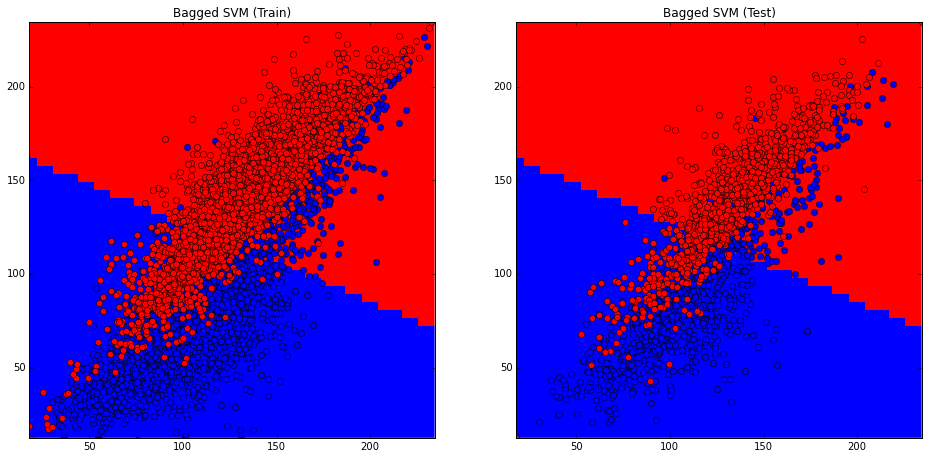

time: 1.69 s


In [98]:
# Colors bagged SVM
model = SVM_Bagging(num_bags=100, size_percent=0.1)
model.train(np.transpose((train_colors, norm_train_Y)))
test_results = model.test(np.transpose((test_colors, norm_test_Y)), display=True)
model.plot_model(np.transpose((train_colors, norm_train_Y)), np.transpose((test_colors, norm_test_Y)), display=True)

### SVM k-Fold Cross-Validation

In [8]:
class SVM_k_Cross(BaseModel):
    def __init__(self, k=5):
        self.k = k
    
    def train(self, XY_train):
        XY_train = np.array(XY_train)
        # Shuffle
        XY_train = XY_train[np.random.choice(range(XY_train.shape[0]), XY_train.shape[0], replace=False), :]
        # Create the folds
        step_size = XY_train.shape[0] // self.k
        folds = np.array([XY_train[x:x+step_size] for x in range(0, XY_train.shape[0], step_size)])
        # Determine the best
        classifiers = []
        for test_num in xrange(self.k):
            tmp_XY_train = np.vstack(np.delete(folds, test_num, axis=0))
            tmp_XY_test = folds[test_num]
            # calculate normal vector
            w = np.average(np.array([x for x, y in tmp_XY_train if y==1]), axis=0) - \
                    np.average(np.array([x for x, y in tmp_XY_train if y==0]), axis=0)
            # calculate offset term
            b = 1./len(tmp_XY_train)*sum([np.dot(w,x)-float(y) for x, y in tmp_XY_train])
            self.w = w
            self.b = b
            classifiers.append([w, b, self.test(tmp_XY_test, display=False)])
        # Pick best classifier
        best_ind = -1
        best_avg = -1
        for ind, classifier in enumerate(classifiers):
            tmp_avg = np.average([classifier[-1]['accuracy'], classifier[-1]['precision'], classifier[-1]['recall']])
            if tmp_avg > best_avg:
                best_ind = ind
        # Set weight and bias values for best classifier
        self.w = classifiers[best_ind][0]
        self.b = classifiers[best_ind][1]
    
    def predict(self, x):
        # get sign and then scale it to the range (0,1)
        prediction = (np.sign(np.dot(self.w,x)-self.b)+1)/2
        return prediction
    
    def name(self):
        return '{0}-Fold Cross Validated SVM'.format(self.k)

time: 30.1 ms


Fitted 15-Fold Cross Validated SVM Results
Accuracy: 76.95%
Precision: 77.11%
Recall: 76.72%


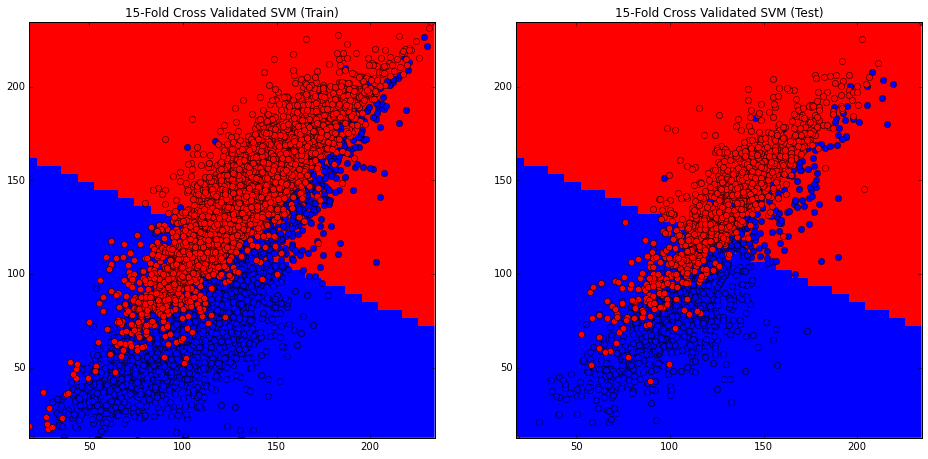

time: 854 ms


In [196]:
# k-Fold Cross Validated SVM
k = 15
model = SVM_k_Cross(k=k)
model.train(np.transpose((train_colors, norm_train_Y)))
test_results = model.test(np.transpose((test_colors, norm_test_Y)), display=True)
model.plot_model(np.transpose((train_colors, norm_train_Y)), np.transpose((test_colors, norm_test_Y)), display=True)

### Regular kNN

In [31]:
class KNN(BaseModel):
    def __init__(self, XY_train, k=1):
        self.XY_train = XY_train
        self.k = k
    
    def train(self, XY_train=None, k=None):
        if XY_train is not None:
            self.XY_train = XY_train
        if k is not None:
            self.k = k
    
    def predict(self, x):
        distance_label_list = [(np.linalg.norm(x-x_train), y_train) for x_train, y_train in self.XY_train]
        distance_label_list.sort()
        return np.average([label for distance, label in distance_label_list[:self.k]])
    
    def name(self):
        return 'kNN-%i' % self.k

time: 28.7 ms


Fitted kNN-1 Results
Accuracy: 82.65%
Precision: 82.83%
Recall: 82.42%


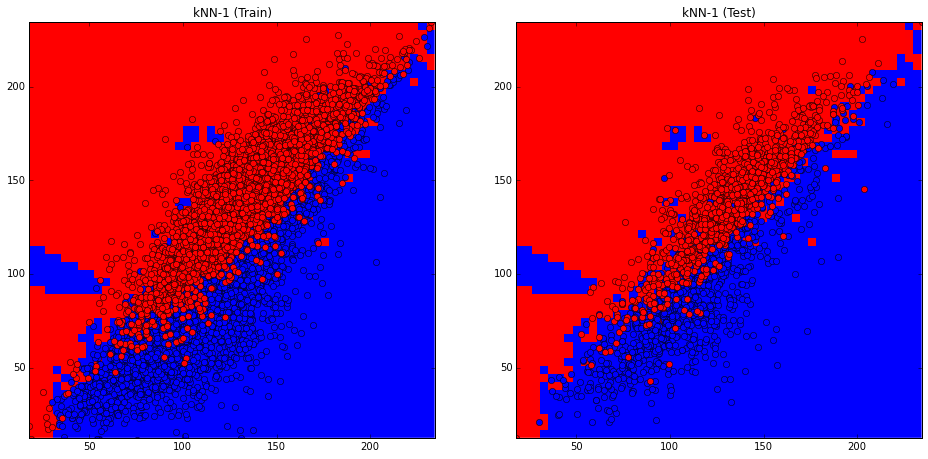

time: 4min 29s


In [105]:
# kNN-1
k = 1
model = KNN()
model.train(np.transpose((train_colors, norm_train_Y)), k)
test_results = model.test(np.transpose((test_colors, norm_test_Y)), display=True)
model.plot_model(np.transpose((train_colors, norm_train_Y)), np.transpose((test_colors, norm_test_Y)), display=True)

Fitted kNN-10 Results
Accuracy: 86.45%
Precision: 85.03%
Recall: 88.51%


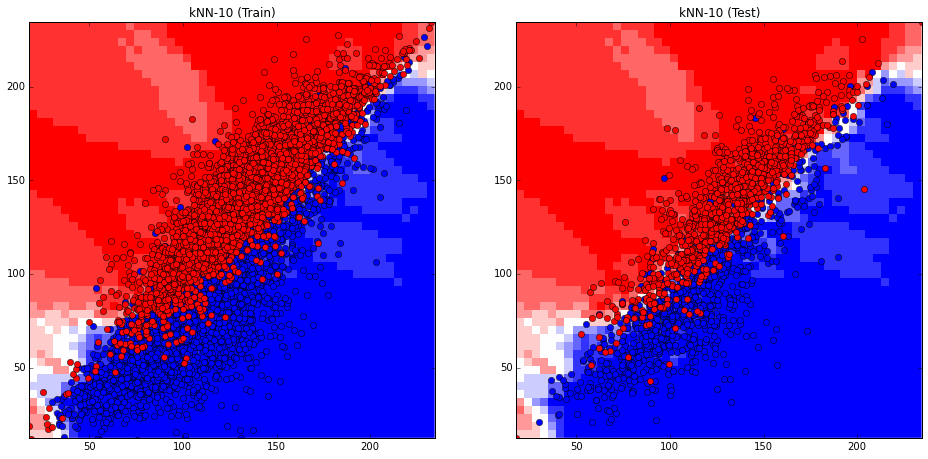

time: 4min 30s


In [106]:
# kNN-10
k = 10
model = KNN()
model.train(np.transpose((train_colors, norm_train_Y)), k)
test_results = model.test(np.transpose((test_colors, norm_test_Y)), display=True)
model.plot_model(np.transpose((train_colors, norm_train_Y)), np.transpose((test_colors, norm_test_Y)), display=True)

### kNN Bagging

In [ ]:
class KNN_Bagging(BaseModel):
    def __init__(self, k=1):
        self.k = k
    
    def train(self, XY_train, k=None, num_bootstrap=5, bootstrap_size=None):
        XY_train = np.array(XY_train)
        if bootstrap_size is None:
            bootstrap_size = XY_train.shape[0]
        if k is not None:
            self.k = k
        self.models = []
        for _ in range(num_bootstrap):
            bootstrap_data = XY_train[np.random.choice(range(XY_train.shape[0]), bootstrap_size, replace=False), :]
            self.models.append(KNN(bootstrap_data, k))
            
    def predict(self, point):
        predictions = []
        for model in self.models:
            predictions.append(model.predict(point))
        return np.average(predictions)
    
    def name(self):
        return 'kNN-%i' % self.k

Fitted kNN-1 Results
Accuracy: 84.10%
Precision: 84.60%
Recall: 83.42%


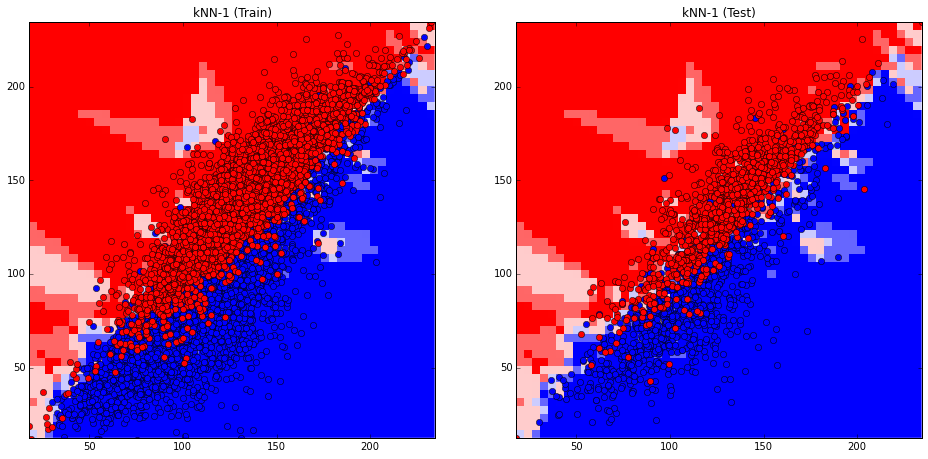

time: 6min 8s


In [32]:
k = 1
model = KNN_Bagging()
model.train(np.transpose((train_colors, norm_train_Y)), k=k, num_bootstrap=5, bootstrap_size=len(train_colors) // 3)
test_results = model.test(np.transpose((test_colors, norm_test_Y)), display=True)
model.plot_model(np.transpose((train_colors, norm_train_Y)), np.transpose((test_colors, norm_test_Y)), display=True)

Fitted kNN-10 Results
Accuracy: 86.95%
Precision: 86.13%
Recall: 88.11%


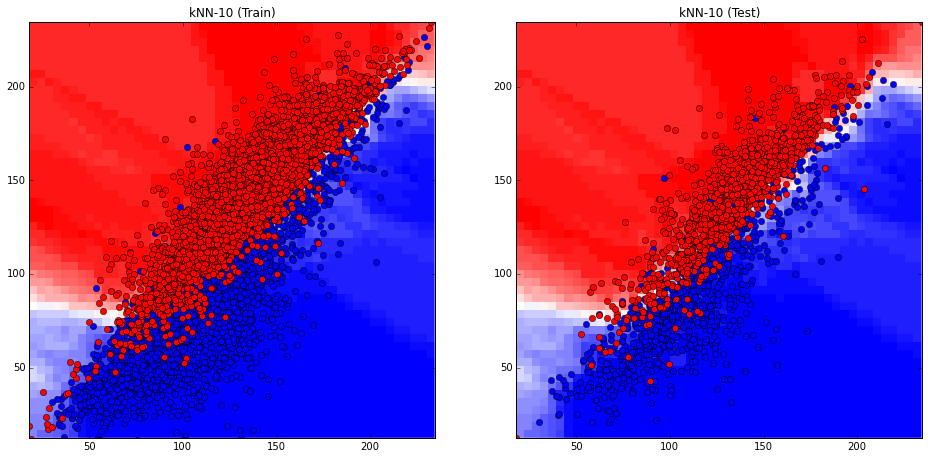

time: 6min 8s


In [33]:
k = 10
model = KNN_Bagging()
model.train(np.transpose((train_colors, norm_train_Y)), k=k, num_bootstrap=5, bootstrap_size=len(train_colors) // 3)
test_results = model.test(np.transpose((test_colors, norm_test_Y)), display=True)
model.plot_model(np.transpose((train_colors, norm_train_Y)), np.transpose((test_colors, norm_test_Y)), display=True)

## Plotting for H/S/L -- Retained for posterity

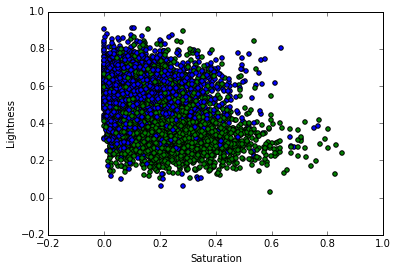

time: 32.3 s


In [7]:
# Plot HSL
fig = plt.figure()
ax = fig.add_subplot(111)
for ind, datum in enumerate(data):
    if meta['label_names'][labels[ind]] == 'ship':
        c = 'b'
    elif meta['label_names'][labels[ind]] == 'frog':
        c = 'g'
    else:
        continue
    tmp_image = datum
    red = tmp_image[:, :, 0]
    green = tmp_image[:, :, 1]
    blue = tmp_image[:, :, 2]
    hue = np.average(np.arctan2(((3)**(1/2)/2.) * (green - blue), 2*red - green - blue))
    lightness = np.average(0.5 * (np.min([np.average(red), np.average(green), np.average(blue)]) + 
                                  np.max([np.average(red), np.average(green), np.average(blue)]))) / 255.
    C = float(np.max([np.average(red), np.average(green), np.average(blue)]) - 
              np.min([np.average(red), np.average(green), np.average(blue)]))
    saturation = 0 if C==0 else C / (1 - np.abs(2*lightness - 1.)) / 255.
    # You can choose two of the following at any time to display: [hue, saturation, lightness]
    # Make sure you adjust the axes labels below accordingly
    ax.scatter(saturation, lightness, c=c)
ax.set_xlabel('Saturation')
ax.set_ylabel('Lightness')

## HSL Calculations -- Retained for posterity

In [14]:
# Get the HSL values for the train and test sets
train_test_HSL = {'train': [], 'test': []}
for ind, tmp_data in enumerate([train_X, test_X]):
    for tmp_image in tmp_data:
        red = tmp_image[:, :, 0]
        green = tmp_image[:, :, 1]
        blue = tmp_image[:, :, 2]
        hue = np.average(np.arctan2(((3)**(1/2)/2.) * (green - blue), 2*red - green - blue))
        lightness = np.average(0.5 * (np.min([np.average(red), np.average(green), np.average(blue)]) + 
                                      np.max([np.average(red), np.average(green), np.average(blue)]))) / 255.
        C = float(np.max([np.average(red), np.average(green), np.average(blue)]) - 
                  np.min([np.average(red), np.average(green), np.average(blue)]))
        saturation = 0 if C==0 else C / (1 - np.abs(2*lightness - 1.)) / 255.
        if ind == 0:
            train_test_HSL['train'].append({'hue': hue, 'saturation': saturation, 'lightness': lightness})
        else:
            train_test_HSL['test'].append({'hue': hue, 'saturation': saturation, 'lightness': lightness})

time: 2.16 s


In [15]:
# Create the binary splits
train_HS = tuple(np.transpose([[x['hue'] for x in train_test_HSL['train'][:]], [x['saturation'] for x in train_test_HSL['train'][:]]]))
test_HS = tuple(np.transpose([[x['hue'] for x in train_test_HSL['test'][:]], [x['saturation'] for x in train_test_HSL['test'][:]]]))

train_SL = tuple(np.transpose([[x['saturation'] for x in train_test_HSL['train'][:]], [x['lightness'] for x in train_test_HSL['train'][:]]]))
test_SL = tuple(np.transpose([[x['saturation'] for x in train_test_HSL['test'][:]], [x['lightness'] for x in train_test_HSL['test'][:]]]))

train_HL= tuple(np.transpose([[x['hue'] for x in train_test_HSL['train'][:]], [x['lightness'] for x in train_test_HSL['train'][:]]]))
test_HL = tuple(np.transpose([[x['hue'] for x in train_test_HSL['test'][:]], [x['lightness'] for x in train_test_HSL['test'][:]]]))

time: 22.3 ms


# Homework:
##### Submit to @have_uh_cot_ee or [keenan.hawekotte@hudl.com](keenan.hawekotte@hudl.com)

### 1) 2x2 Confusion Matrix and APR
Calculate the APR for the following confusion matrix:
<img align=center src="http://www.dataschool.io/content/images/2015/01/confusion_matrix2.png">

### 2) 3x3 Confusion Matrix and APR
Calculate the APR for the following confusion matrix:
<img align=center width=450 src="http://i.imgur.com/yimrJ79.png">

### 3) Apply SVM and kNN bagging to HSL values and report APR metrics
Run the HSL (choose two of the three to compare against each other) through both the bagged SVM and bagged kNN. Then report the values below.

### Bonus) 
Apply your chosen HSL features above to the k-Fold cross-validated SVM and compare it to the normal HSL SVM. State what changed and why.